In [1]:
# 네이버 검색 API 예제 - 블로그 검색
import pandas as pd
import requests
import os
import sys
import urllib.request
import json
import datetime
import xlsxwriter
import numpy as np

## 크롤링
책의 가격은 어떻게 결정될 것인가? 에 대한 답을 찾기 위한 연구

In [35]:
def get_search_order():
    keyword = input("키워드 : ")
      
    return keyword

def get_client_info():
    client = pd.read_csv('~/API/naver_API.csv')
    client_id = client.loc[0,'client_id']
    client_secret = client.loc[0,'client_secret']
    print(client_id)

    return client_id,client_secret

def gen_search_url(node, search_text, start_num, disp_num):
    base = "https://openapi.naver.com/v1/search"
    node = "/" + node + ".json"
    param_query = "?query=" + urllib.parse.quote(search_text)
    param_start = "&start=" + str(start_num)
    param_disp = "&display=" + str(disp_num)
    
    return base + node + param_query + param_start + param_disp

def get_result_onpage(client_id,client_secret,url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    print("[%s] Url Requests Success" % datetime.datetime.now())

    return json.loads(response.read().decode("utf-8"))

def get_fields(json_data):
    title = [delete_tag(i["title"]) for i in json_data["items"]]
    publisher = [i["publisher"] for i in json_data["items"]]
    author = [i["author"] for i in json_data["items"]]
    price = [delete_tag(i["discount"]) for i in json_data["items"]]
    link = [delete_tag(i["link"]) for i in json_data["items"]]
    df = pd.DataFrame({
        "title" : title,
        "publisher" : publisher,
        "author" : author,
        "price" : price,
        "link" : link,
        })
    return df

def delete_tag(input_str):
    input_str = input_str.replace("<b>","")
    input_str = input_str.replace("</b>","")
    return input_str

def actMain(kwd):
    total_result = []
    client_id,client_secret = get_client_info()
    for i in range(1,1000,100):
        url = gen_search_url("book",kwd,i,100)
        one_result = get_result_onpage(client_id,client_secret,url)

        df = get_fields(one_result)      
        total_result.append(df)
    
    total_result = pd.concat(total_result)
    total_result.reset_index(drop=True, inplace=True)
    return total_result

def export_file(keyword,total_result):
    writer = pd.ExcelWriter(f"/Users/young/git/project/export/{keyword}_{datetime.datetime.now()}.xlsx", engine="xlsxwriter")
    total_result.to_excel(writer,sheet_name='Sheet1')
    workbook = writer.book
    worksheet = writer.sheets["Sheet1"]
    writer.save()
    pass

def init():
    keyword = get_search_order()
    total_result = actMain(keyword)
    return total_result
    # export_file(keyword,total_result)

df = init()


In [54]:
df['price']=df['price'].astype(int)
df.info()
df = df[df['price']>0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      855 non-null    object
 1   publisher  855 non-null    object
 2   author     855 non-null    object
 3   price      855 non-null    int64 
 4   link       855 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.5+ KB


In [120]:
from bs4 import BeautifulSoup
from urllib.request import Request,urlopen
import requests
import re
from fake_useragent import UserAgent

In [124]:
    ua = UserAgent()
    url = df['link'][0]
    hdr = {'User-Agent': ua.random}
    req = requests.get(url,headers=hdr)
    BeautifulSoup(req.text,'lxml')

<!DOCTYPE html>
<html lang="ko"><head><meta charset="utf-8"/><meta content="no-cache, no-store, must-revalidate" http-equiv="Cache-Control"/><meta content="width=device-width, initial-scale=1, shrink-to-fit=no, minimum-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport"/><title>네이버 도서</title><link href="https://ssl.pstatic.net/shoppingsearch/static/book-catalog/book-catalog-230314-113259/img/favicon.ico" rel="shortcut icon"/><link href="https://ssl.pstatic.net/shoppingsearch/static/book-catalog/book-catalog-230314-113259/img/favicon_60.png" rel="apple-touch-icon"/><meta content="네이버 도서" property="og:title"/><meta content="네이버 도서 상세정보를 제공합니다." property="og:description"/><meta content="https://ssl.pstatic.net/imgshopping/static/mo2014/icon/og_shopping_v2.png" property="og:image"/><meta content="https://search.shopping.naver.com/book/catalog" property="og:url"/><meta content="10" name="next-head-count"/><link href="https://static.nid.naver.com" rel="preconnect"/><link href="ht

In [147]:
def get_html(url):
    ua = UserAgent()

    hdr = {'User-Agent': ua.random}
    req = requests.get(url,headers=hdr)
    soup = BeautifulSoup(req.text,'lxml')
    soup.prettify()
    return soup

In [142]:
page = soup.select('div.bookBasicInfo_basic_info__HCWyr > ul > li:nth-child(2)')
page = re.findall(('[0-9]'),page[0].text)
page
# sums = ''
# for i in page:
#     sums += i
# int(sums)

['5', '5', '2', '1', '2', '6', '1', '1', '8', '9', '2', '5', '9', '2', '9']

In [152]:
pages = []

for idx in df['link']:
    soup = ''
    soup = get_html(idx)
    page = soup.select('#book_section-info > div.bookBasicInfo_basic_info__HCWyr > ul > li:nth-child(2) > div > div.bookBasicInfo_info_detail__I0Fx5 > span:nth-child(1)')
    print(idx)    
    try:
        print(page[0].text)

        page = re.findall(('[0-9]'),page[0].text)
        sums = ''
        for i in page:
            sums += i
    except:
        sums = 0
        print(0)
    pages.append(int(sums))
    

https://search.shopping.naver.com/book/catalog/32507605957
552쪽
https://search.shopping.naver.com/book/catalog/32456895000
360쪽
https://search.shopping.naver.com/book/catalog/37741580626
500쪽
https://search.shopping.naver.com/book/catalog/36813141618
0
https://search.shopping.naver.com/book/catalog/32496549634
680쪽
https://search.shopping.naver.com/book/catalog/36925491630
0
https://search.shopping.naver.com/book/catalog/37828235624
436쪽
https://search.shopping.naver.com/book/catalog/34233217628
548쪽
https://search.shopping.naver.com/book/catalog/36555425618
496쪽
https://search.shopping.naver.com/book/catalog/38404352624
0
https://search.shopping.naver.com/book/catalog/32466599747
0
https://search.shopping.naver.com/book/catalog/32505509707
0
https://search.shopping.naver.com/book/catalog/32460987987
608쪽
https://search.shopping.naver.com/book/catalog/32478416791
308쪽
https://search.shopping.naver.com/book/catalog/32440944646
304쪽
https://search.shopping.naver.com/book/catalog/32489150

#### 웹페이지 로딩 에러로 인해 발생한 null값 보충하기

In [255]:
df['page'] = pages
df[df['page']==0]['link']

# df.loc[df['page']==0].index

for i in df.loc[df['page']==0].index:

    soup = get_html(df.loc[i]['link'])
    page = soup.select('#book_section-info > div.bookBasicInfo_basic_info__HCWyr > ul > li:nth-child(2) > div > div.bookBasicInfo_info_detail__I0Fx5 > span:nth-child(1)')  
    try:
        print(page[0].text)

        page = re.findall(('[0-9]'),page[0].text)
        sums = ''
        for j in page:
            sums += j
        df.loc[i,'page'] = sums
    except:
        sums = 0
        print(i)
    

/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


420쪽


/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


552쪽
566쪽
727쪽
480쪽
724쪽
33
560쪽
440쪽
540쪽
43
52
624쪽
346쪽
256쪽
580쪽
58
60
62
64
197쪽
344쪽
247쪽
652쪽
484쪽
82
85
200쪽
95
108
208쪽
120
504쪽
384쪽
320쪽
368쪽
512쪽
133
467쪽
464쪽
142
460쪽
160
316쪽
840쪽
170
251쪽
216쪽
376쪽
374쪽
520쪽
552쪽
744쪽
213
344쪽
217
296쪽
424쪽
239
420쪽
259
248쪽
768쪽
412쪽
308쪽
460쪽
252쪽
274
279
352쪽
305
840쪽
384쪽
262쪽
338쪽
200쪽
346
349
356
527쪽
340쪽
408쪽
192쪽
372
380
288쪽
544쪽
472쪽
576쪽
528쪽
460쪽
434
574쪽
592쪽
176쪽
451
352쪽
116쪽
468
296쪽
470
548쪽
336쪽
228쪽
332쪽
408쪽
448쪽
288쪽
464쪽
380쪽
244쪽
400쪽
384쪽
526
344쪽
380쪽
312쪽
396쪽
520쪽
248쪽
390쪽
380쪽
570쪽
581
400쪽
586
528쪽
448쪽
388쪽
487쪽
328쪽
272쪽
520쪽
215쪽
400쪽
332쪽
212쪽
368쪽
670
176쪽
679
424쪽
466쪽
264쪽
409쪽
694
400쪽
705
376쪽
332쪽
735
592쪽
392쪽
86쪽
404쪽
416쪽
724쪽
136쪽
305쪽
356쪽
868쪽
784
644쪽
408쪽
192쪽
508쪽
539쪽
818
820
526쪽
826
324쪽
833
834
336쪽
528쪽
192쪽
838
839
320쪽
484쪽
844
1164쪽
260쪽
392쪽
848
849
536쪽
316쪽
852
344쪽
964쪽


In [265]:
# df = df[df['page']!=0]
df['page'] = df['page'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736 entries, 0 to 854
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      736 non-null    object
 1   publisher  736 non-null    object
 2   author     736 non-null    object
 3   price      736 non-null    int64 
 4   link       736 non-null    object
 5   page       736 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 40.2+ KB


/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 페이지와 책 가격의 상관관계1

<AxesSubplot:xlabel='page', ylabel='price'>

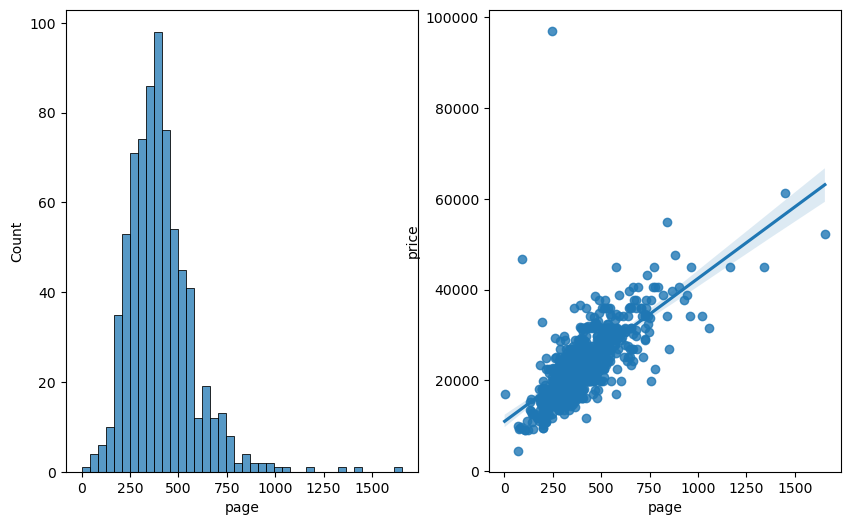

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(10,6))
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.histplot(df['page'], ax=axes[0])
sns.regplot(data=df, x='page', y='price', ax=axes[1])
# sns.lmplot(data=df,x='page',y='price',ax=axes[1])

In [384]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def get_fit_predict(df):
    X = df['page'].values
    y = df['price'].values

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=13)

    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)
    # y_train.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    return pred_train,pred_test,y_train,y_test

### 책 가격과 페이지 수의 상관관계는 존재하나, 예측할만한 지표는 아님

In [403]:
from sklearn.metrics import r2_score

def get_score(pred_train,pred_test,y_train,y_test):
    mse = mean_squared_error(y_test, pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred_test)

    # print(f'Mean Squared Error: {mse:.3f}')
    # print(f'Root Mean Squared Error: {rmse:.3f}')
    # print(f'R-squared: {r2:.3f}')

    return rmse,r2

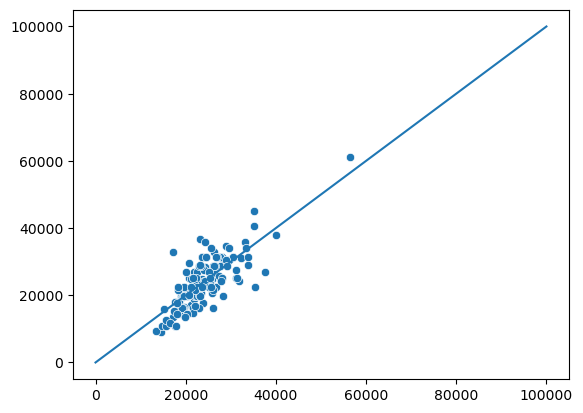

In [327]:
sns.scatterplot(x=pred_test,y=y_test)
plt.plot([0,100000],[0,100000])

# pred_test.reshape(-1,1)


### 출판사별로 쪼개봤을때, 선형관계가 강한 출판사와 그렇지 않은 아웃라이어 존재

In [378]:
publisher_mean_price = df.groupby(['publisher','page','title']).agg({'price':'first'}).reset_index()
publisher_counta = df.groupby(['publisher']).title.apply(lambda x : len(np.unique(x))).reset_index().sort_values(by='title',ascending=False)

publisher_counta_1q = publisher_counta.head(int(len(publisher_counta)*0.25))
list(publisher_counta_1q.publisher)

df_1q = df[df['publisher'].isin((publisher_counta_1q.publisher))]


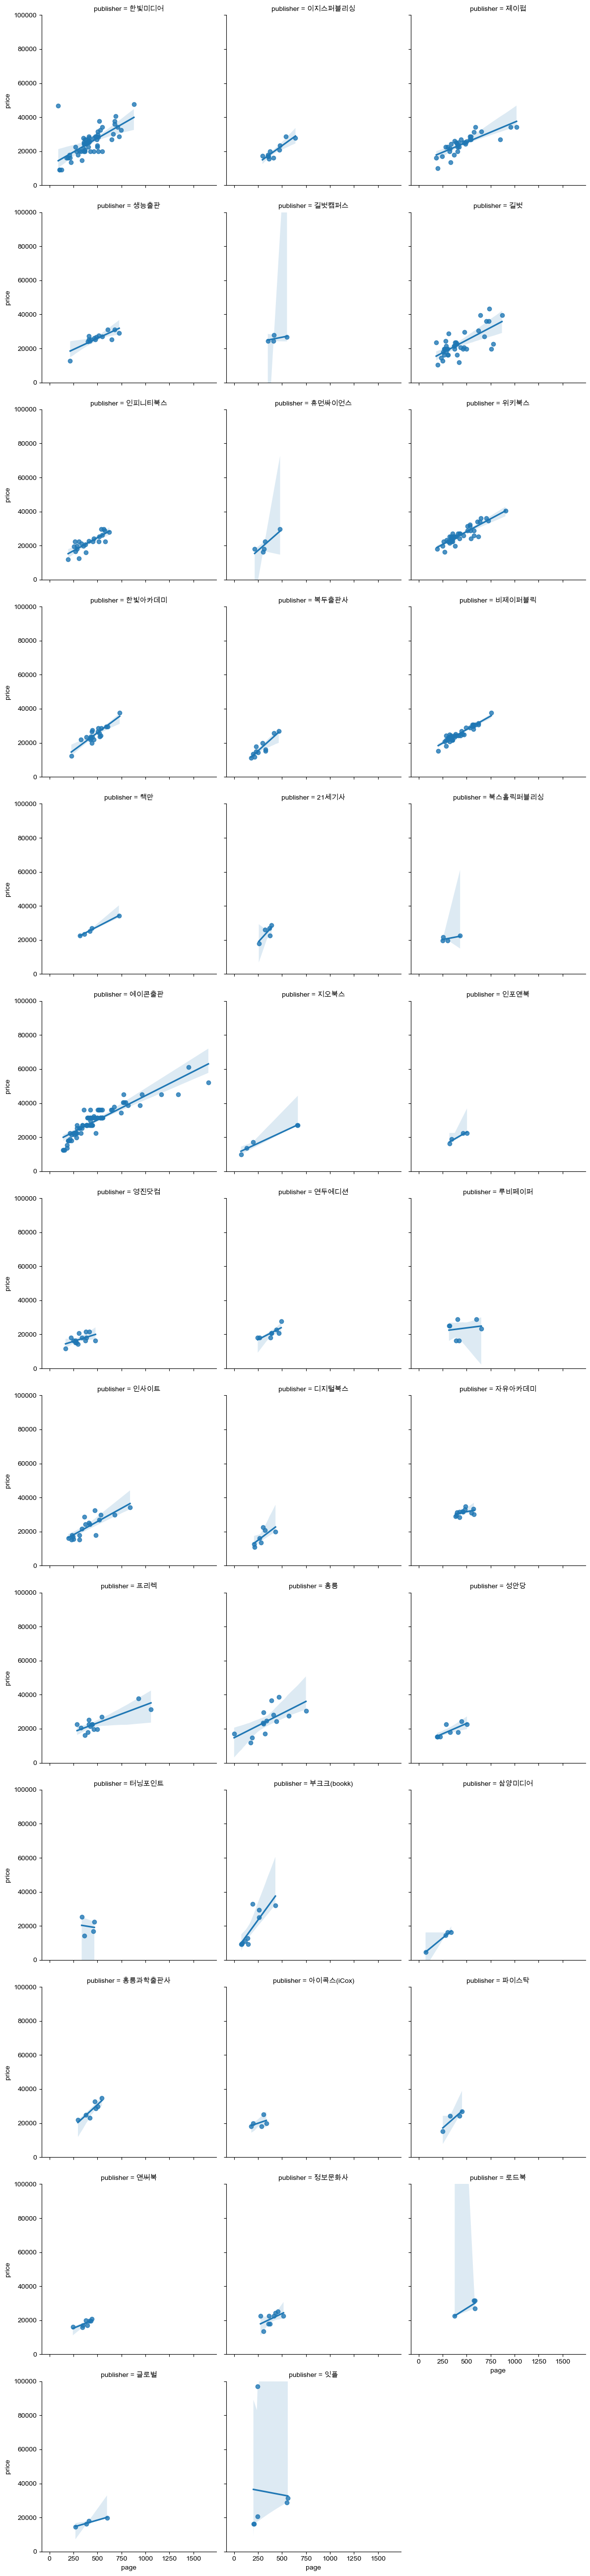

In [379]:
from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()

from matplotlib import rc
plt.rcParams["axes.unicode_minus"] = False 
rc('font', family='Arial Unicode MS')
%matplotlib inline
get_ipython().run_line_magic("matplotlib","inline")


g = sns.FacetGrid(df_1q, col='publisher', col_wrap=3, height=4)
g.map(sns.regplot, 'page', 'price')
g.set(ylim=(0,100000))

In [404]:
rmse_list = []
r2_list = []
pub = (list(publisher_counta_1q.publisher))
# publisher_counta_1q

for i in pub:
    df_select = df_1q[df_1q['publisher']==i]
    pred_train,pred_test,y_train,y_test = get_fit_predict(df_select)
    rmse,r2 = get_score(pred_train,pred_test,y_train,y_test)
    
    rmse_list.append(rmse)
    r2_list.append(r2)


/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/young/opt/anaconda3/envs/test1/lib/python3.7/site-packages/sklearn/metrics/_r

In [429]:
scores_1q = pd.DataFrame({'publisher':pub,'rmse':rmse_list,'r2':r2_list})
scores_1q = pd.merge(scores_1q,publisher_counta_1q,on='publisher',how='left')
scores_1q.rename(columns={'title':'sample'},inplace=True)
scores_1q.sort_values(by='r2',ascending=False)


,publisher,rmse,r2,sample
7,한빛아카데미,620.987827,0.956577,20
2,위키북스,2418.032878,0.791831,44
14,이지스퍼블리싱,1610.153739,0.778422,11
3,비제이퍼블릭,1290.472508,0.757119,39
20,연두에디션,692.723299,0.726670,8
5,제이펍,3850.546521,0.703382,33
8,인사이트,4066.875001,0.679386,18
6,인피니티북스,4348.981309,0.585863,23
0,에이콘출판,5863.698785,0.579477,83
21,디지털북스,3270.187122,0.563550,7
